In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Model explainability
- Feature importance
- Data bias and model bias
- Model risk

In [2]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import joblib
import pandas as pd
import numpy as np

In [3]:
import joblib
import tensorflow as tf

# Load Word2Vec data
X_train_w2v = joblib.load('/content/drive/MyDrive/aap/X_train_w2v.joblib')
X_val_w2v = joblib.load('/content/drive/MyDrive/aap/X_val_w2v.joblib')
X_test_w2v = joblib.load('/content/drive/MyDrive/aap/X_test_w2v.joblib')


y_train_w2v = joblib.load('/content/drive/MyDrive/aap/y_train_w2v.joblib')
y_val_w2v = joblib.load('/content/drive/MyDrive/aap/y_val_w2v.joblib')


y_test = joblib.load('/content/drive/MyDrive/aap/y_test.joblib')


In [8]:
%%time
xgb_clf = XGBClassifier(
        learning_rate=0.1,
        n_estimators=400,
        max_depth=8,
        objective='multi:softmax',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state = 42
    )

    # Train the model


xgb_clf.fit(X_train_w2v, y_train_w2v)

# Make predictions on validation and test sets
y_val_pred = xgb_clf.predict(X_val_w2v)
y_pred_w2v = xgb_clf.predict(X_test_w2v)

# Calculate validation accuracy
val_accuracy = accuracy_score(y_val_w2v, y_val_pred)
# Print the validation accuracy
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

accuracy_cv = accuracy_score(y_test, y_pred_w2v)
report_cv = classification_report(y_test, y_pred_w2v)

print(f"Test Accuracy for word2vec: {accuracy_cv * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:59:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 76.66%
Test Accuracy for word2vec: 90.20%
CPU times: user 8min 47s, sys: 483 ms, total: 8min 47s
Wall time: 1min 11s


## Model Explainability and Feature Importance


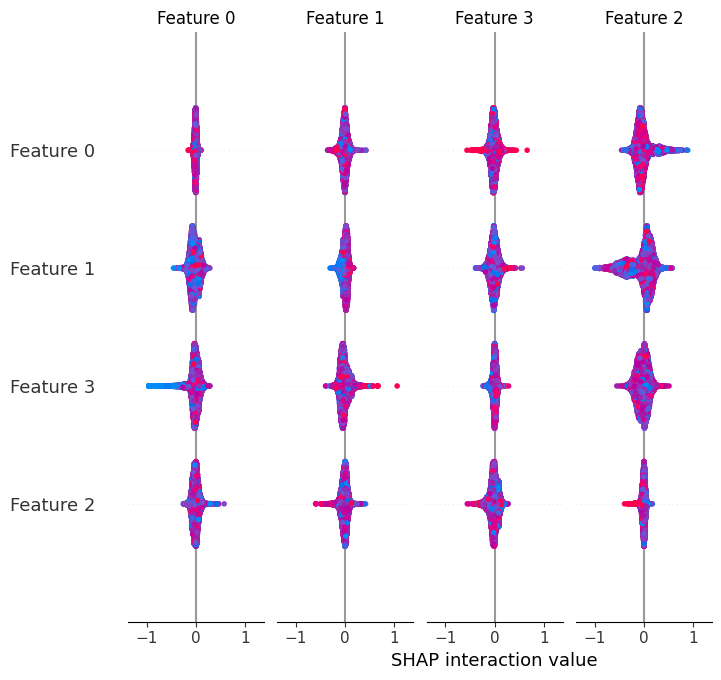

In [35]:
## 1. Model Explainability and Feature Importance
import shap

# Initialize the SHAP explainer on the trained XGBoost model
explainer = shap.TreeExplainer(xgb_clf)
# Calculate SHAP values for the validation set
shap_values = explainer.shap_values(X_val_w2v)

# Summary plot to show the impact of each feature on the model output
shap.summary_plot(shap_values, X_val_w2v, plot_type="bar")

# For a specific prediction, choose an instance to explain (e.g., the first instance)
shap.initjs()

# For a specific instance and class in the validation set
shap.force_plot(explainer.expected_value[0], shap_values[0][:, 0], X_val_w2v[0, :])

## 2. Data Bias and Model Bias

In [13]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Check the class distribution

# Check for performance disparities across classes
print("Validation Classification Report:")
print(classification_report(y_val_w2v, y_val_pred))

# Confusion matrix
cm = confusion_matrix(y_val_w2v, y_val_pred)
print("Confusion Matrix:\n", cm)

# Calculate metrics by class (precision, recall, etc.)
report = classification_report(y_test, y_pred_w2v, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("Detailed classification report:\n", df_report)


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.65      0.70      2474
           1       0.79      0.84      0.81      4260
           2       0.76      0.73      0.75      3397
           3       0.75      0.79      0.77      3768

    accuracy                           0.77     13899
   macro avg       0.77      0.75      0.76     13899
weighted avg       0.77      0.77      0.77     13899

Confusion Matrix:
 [[1598  291  248  337]
 [ 141 3578  239  302]
 [ 178  358 2489  372]
 [ 154  324  300 2990]]
Detailed classification report:
               precision    recall  f1-score   support
0              0.901840  0.854651  0.877612   172.000
1              0.911439  0.928571  0.919926   266.000
2              0.906475  0.884211  0.895204   285.000
3              0.888889  0.924188  0.906195   277.000
accuracy       0.902000  0.902000  0.902000     0.902
macro avg      0.902161  0.897905  0.899734  1000.000
weighted

## Robustness Testing with Adversarial Noise
Adding small perturbations to inputs can help test if the model's predictions are stable and robust to slight variations.

In [38]:
import numpy as np

# Define a small perturbation level
epsilon = 0.05

# Add noise to a sample from X_test and observe the change in predictions
X_test_perturbed = X_test_w2v + epsilon * np.random.normal(size=X_test_w2v.shape)

# Get predictions on perturbed data
y_pred_perturbed = xgb_clf.predict(X_test_perturbed)

# Compare predictions with the original test set
from sklearn.metrics import accuracy_score

robustness_score = accuracy_score(y_pred_w2v, y_pred_perturbed)
print(f"Robustness Score (accuracy on perturbed data): {robustness_score * 100:.2f}%")


Robustness Score (accuracy on perturbed data): 82.80%


compare with 90.2 not so bad with noise
